In [30]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score


In [32]:
spark = SparkSession.builder.appName('Practise').getOrCreate()

In [33]:
spark

In [34]:
df=spark.read.csv("diabetes.csv")

In [35]:
df = spark.read.option('header','true').csv('diabetes.csv')

In [36]:
type(df)

pyspark.sql.dataframe.DataFrame

In [37]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|  31|                   0.248| 26|      1|


In [38]:
df.printSchema()
#Same as .info() with pandas library

root
 |-- Pregnancies: string (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- BloodPressure: string (nullable = true)
 |-- SkinThickness: string (nullable = true)
 |-- Insulin: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- DiabetesPedigreeFunction: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Outcome: string (nullable = true)



In [39]:
df.select(['Age','Outcome']).show()

+---+-------+
|Age|Outcome|
+---+-------+
| 50|      1|
| 31|      0|
| 32|      1|
| 21|      0|
| 33|      1|
| 30|      0|
| 26|      1|
| 29|      0|
| 53|      1|
| 54|      1|
| 30|      0|
| 34|      1|
| 57|      0|
| 59|      1|
| 51|      1|
| 32|      1|
| 31|      1|
| 31|      1|
| 33|      0|
| 32|      1|
+---+-------+
only showing top 20 rows



In [40]:
df.dtypes

[('Pregnancies', 'string'),
 ('Glucose', 'string'),
 ('BloodPressure', 'string'),
 ('SkinThickness', 'string'),
 ('Insulin', 'string'),
 ('BMI', 'string'),
 ('DiabetesPedigreeFunction', 'string'),
 ('Age', 'string'),
 ('Outcome', 'string')]

In [41]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [42]:
from pyspark.sql.functions import col, sum, isnan, when, count

In [43]:
num_rows = df.count()
num_cols = len(df.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  768
Number of columns:  9


In [44]:
### checking the number of null values in each column 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [45]:
df.filter("Age<=21").show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          1|     73|           50|           10|      0|  23|                   0.248| 21|      0|
|          2|     84|            0|            0|      0|   0|                   0.304| 21|      0|
|          1|     80|           55|            0|      0|19.1|                   0.258| 21|      0|
|          2|    142|           82|           18|     64|24.7|                   0.761| 21|      0|
|          0|    125|           96|            0|      0|22.5|                   0.262| 21|      0|
|          1|    126|           56|           29|    152|28.7|                   0.801| 21|      0|


In [46]:
df.select('Age', 'Outcome').filter((col('Age')<=21 )& (col('Outcome') == 1)).show()

+---+-------+
|Age|Outcome|
+---+-------+
| 21|      1|
| 21|      1|
| 21|      1|
| 21|      1|
| 21|      1|
+---+-------+



In [47]:
### Mean of blood pressure
from pyspark.sql.functions import mean

bloodp = df.select(mean("BloodPressure")).collect()[0][0]
print(bloodp)

69.10546875


In [48]:
df.filter("BloodPressure<69.10546875").show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          3|     78|           50|           32|     88|  31|                   0.248| 26|      1|
|         10|    115|            0|            0|      0|35.3|                   0.134| 29|      0|
|          1|    189|           60|           23|    846|30.1|                   0.398| 59|      1|


In [49]:
from pyspark.sql.functions import corr
from pyspark.ml.feature import VectorAssembler

correlation_matrix = df.select([corr(col1, col2).alias(f"{col1}_{col2}") for col1 in df.columns for col2 in df.columns]).toPandas()

print(correlation_matrix)

   Pregnancies_Pregnancies  Pregnancies_Glucose  Pregnancies_BloodPressure  \
0                      1.0             0.129459                   0.141282   

   Pregnancies_SkinThickness  Pregnancies_Insulin  Pregnancies_BMI  \
0                  -0.081672            -0.073535         0.017683   

   Pregnancies_DiabetesPedigreeFunction  Pregnancies_Age  Pregnancies_Outcome  \
0                             -0.033523         0.544341             0.221898   

   Glucose_Pregnancies  ...  Age_Outcome  Outcome_Pregnancies  \
0             0.129459  ...     0.238356             0.221898   

   Outcome_Glucose  Outcome_BloodPressure  Outcome_SkinThickness  \
0         0.466581               0.065068               0.074752   

   Outcome_Insulin  Outcome_BMI  Outcome_DiabetesPedigreeFunction  \
0         0.130548     0.292695                          0.173844   

   Outcome_Age  Outcome_Outcome  
0     0.238356              1.0  

[1 rows x 81 columns]


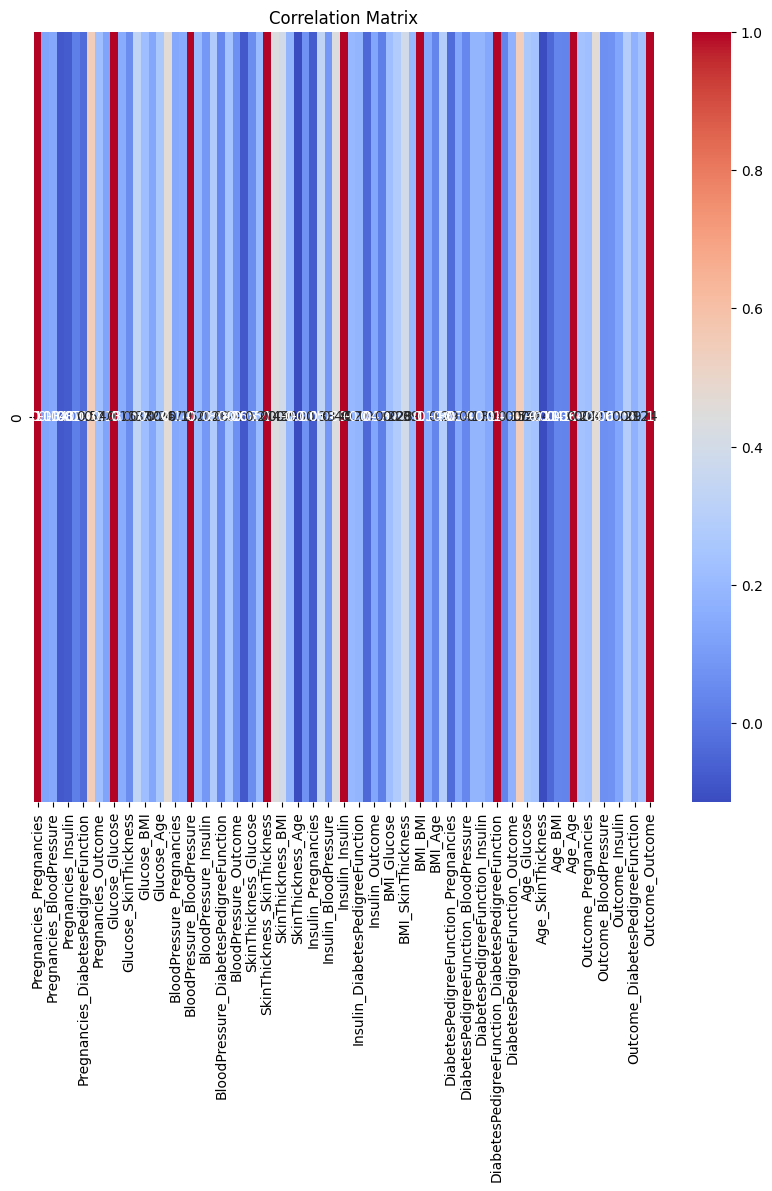

In [50]:
# Compute the correlation matrix as a PySpark DataFrame
correlation_matrix = df.select([corr(col1, col2).alias(f"{col1}_{col2}") for col1 in df.columns for col2 in df.columns]).toPandas()

# Create a heatmap using Seaborn
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, ax=ax)
plt.title("Correlation Matrix")
plt.show()

In [51]:
from pyspark.sql.types import IntegerType

# Convertir les colonnes en int & float
for c in df.columns:
        df = df.withColumn(c, col(c).cast(IntegerType()))
#df = df.withColumn("BMI", col("BMI").cast("float"))
#df = df.withColumn("DiabetesPedigreeFunction", col("DiabetesPedigreeFunction").cast("float"))
df.dtypes


[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'int'),
 ('DiabetesPedigreeFunction', 'int'),
 ('Age', 'int'),
 ('Outcome', 'int')]

Correlation between col1 and col2:  0.23835598302719757


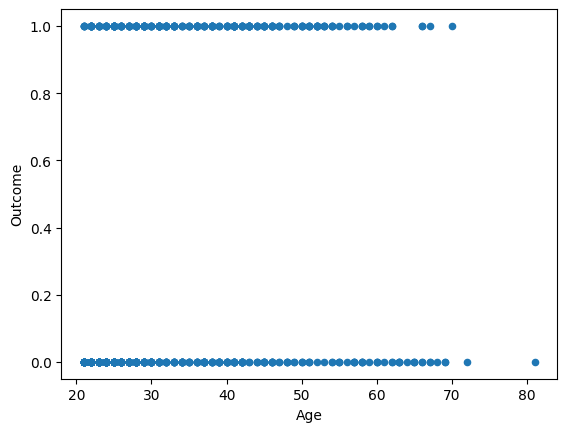

In [52]:
from pyspark.sql.functions import corr

# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Age', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('Age', 'Outcome').toPandas().plot(kind='scatter', x='Age', y='Outcome')
plt.show()


Correlation between Pregnancies and Outcome:  0.22189815303398636


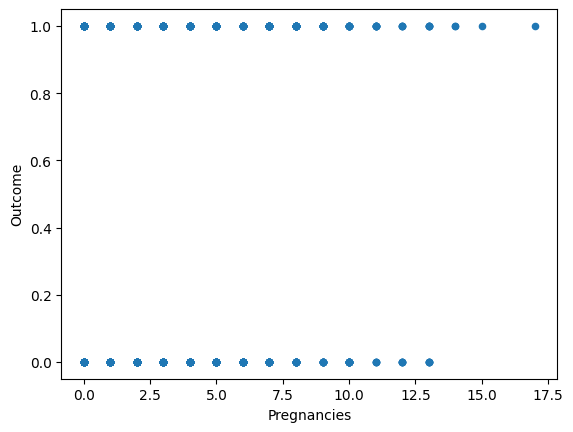

In [53]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Pregnancies', 'Outcome')

# Affichage de la corrélation
print('Correlation between Pregnancies and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('Pregnancies', 'Outcome').toPandas().plot(kind='scatter', x='Pregnancies', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.4665813983068737


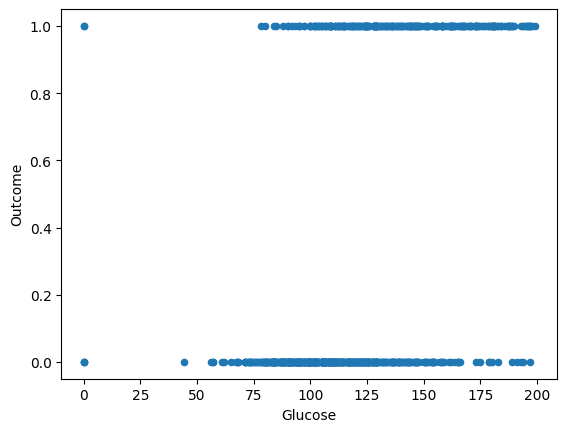

In [54]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Glucose', 'Outcome')

# Affichage de la corrélation
print('Correlation between Glucose and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('Glucose', 'Outcome').toPandas().plot(kind='scatter', x='Glucose', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.06506835955033274


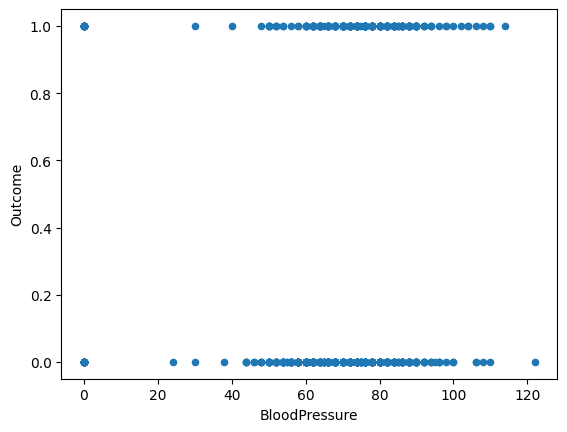

In [55]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('BloodPressure', 'Outcome')

# Affichage de la corrélation
print('Correlation between BloodPressure and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('BloodPressure', 'Outcome').toPandas().plot(kind='scatter', x='BloodPressure', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.07475223191831945


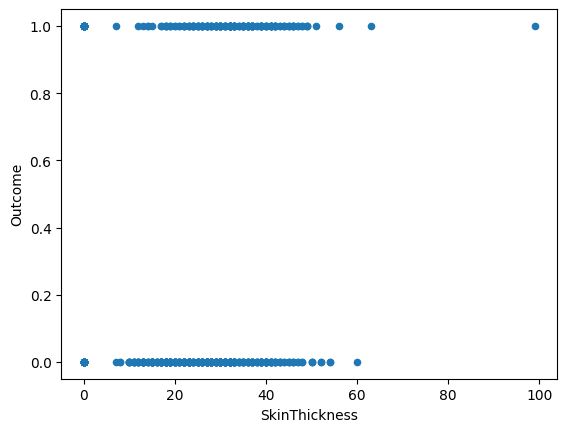

In [56]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('SkinThickness', 'Outcome')

# Affichage de la corrélation
print('Correlation between SkinThickness and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('SkinThickness', 'Outcome').toPandas().plot(kind='scatter', x='SkinThickness', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.13054795488404794


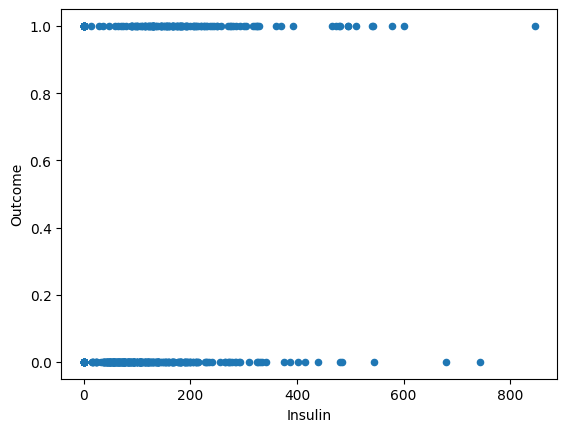

In [57]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Insulin', 'Outcome')

# Affichage de la corrélation
print('Correlation between Insulin and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('Insulin', 'Outcome').toPandas().plot(kind='scatter', x='Insulin', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.29249363017685065


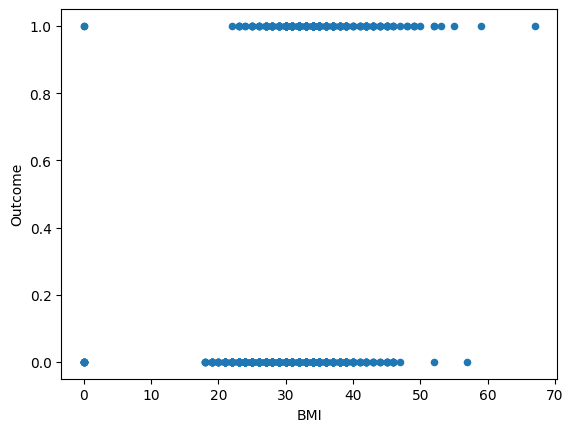

In [58]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('BMI', 'Outcome')

# Affichage de la corrélation
print('Correlation between BMI and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('BMI', 'Outcome').toPandas().plot(kind='scatter', x='BMI', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.12616369074433847


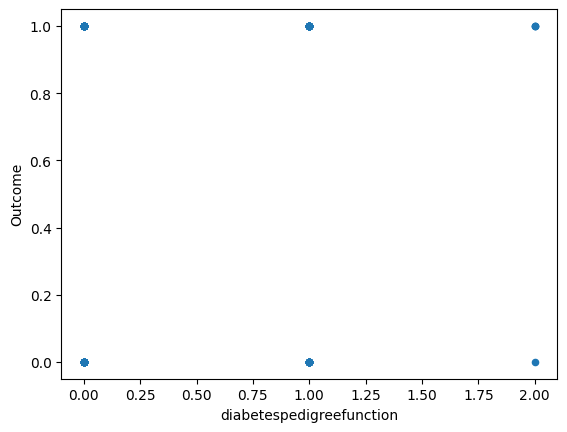

In [59]:

# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('diabetespedigreefunction', 'Outcome')

# Affichage de la corrélation
print('Correlation between diabetespedigreefunction and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('diabetespedigreefunction', 'Outcome').toPandas().plot(kind='scatter', x='diabetespedigreefunction', y='Outcome')
plt.show()

<AxesSubplot: >

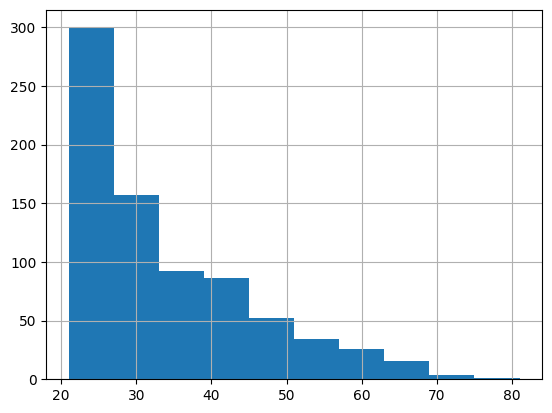

In [60]:
from pyspark_dist_explore import hist

age_series = df.select(col('Age')).toPandas()['Age']
age_series.hist()

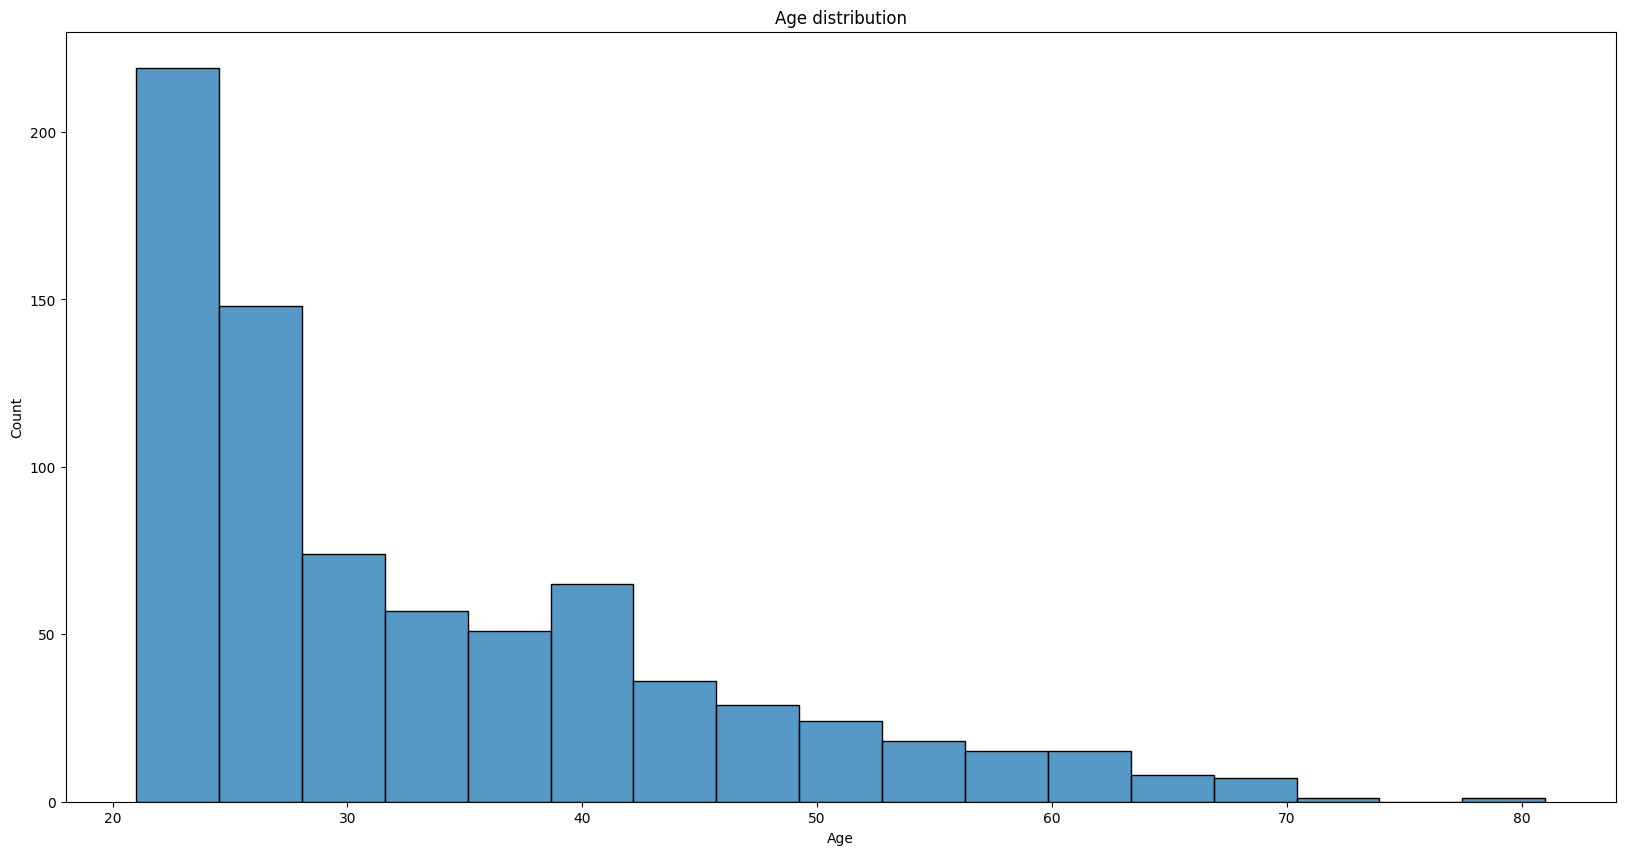

In [77]:
#sns.displot(df['Age'], kde=False).set_title('age')

ages = df.select(col('Age')).toPandas()
sns.histplot(data=ages, x='Age', kde=False)
plt.title('Age distribution')
plt.show()

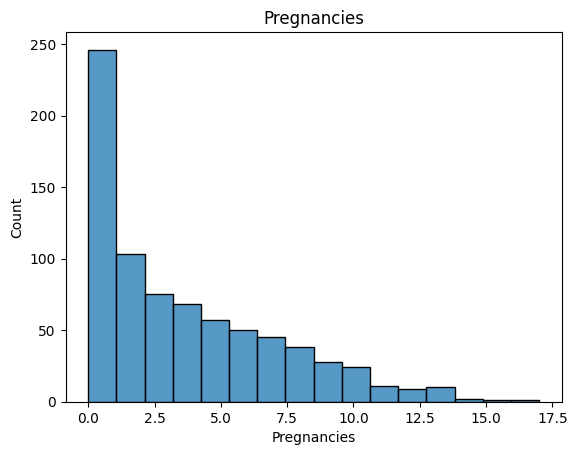

In [62]:
#sns.displot(df['Pregnancies'], kde=False).set_title('Pregnancies')

pregnancies = df.select(col('Pregnancies')).toPandas()
sns.histplot(data=pregnancies, x='Pregnancies', kde=False)
plt.title('Pregnancies')
plt.show()

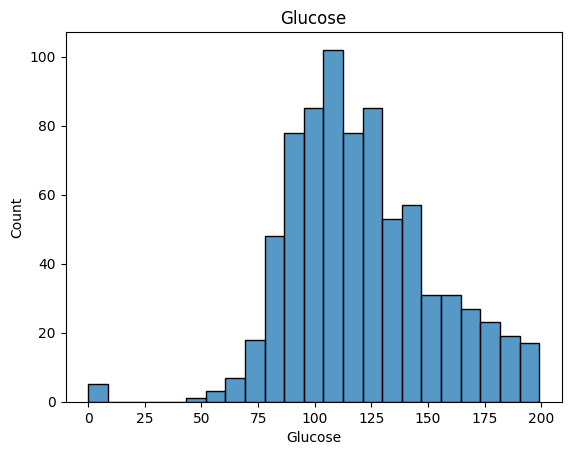

In [63]:
#sns.distplot(df['Glucose'], kde=False).set_title('Glucose')

pregnancies = df.select(col('Glucose')).toPandas()
sns.histplot(data=pregnancies, x='Glucose', kde=False)
plt.title('Glucose')
plt.show()

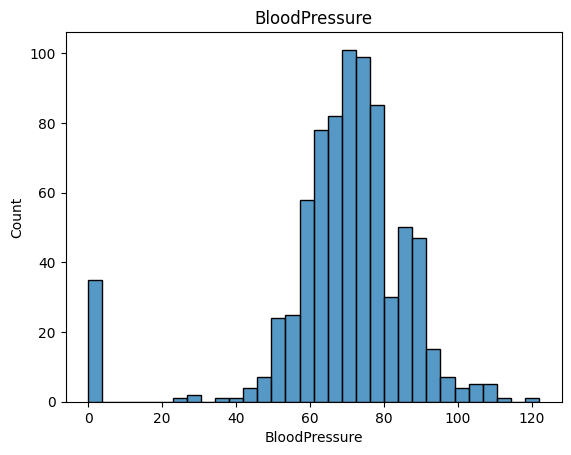

In [64]:
pregnancies = df.select(col('BloodPressure')).toPandas()
sns.histplot(data=pregnancies, x='BloodPressure', kde=False)
plt.title('BloodPressure')
plt.show()

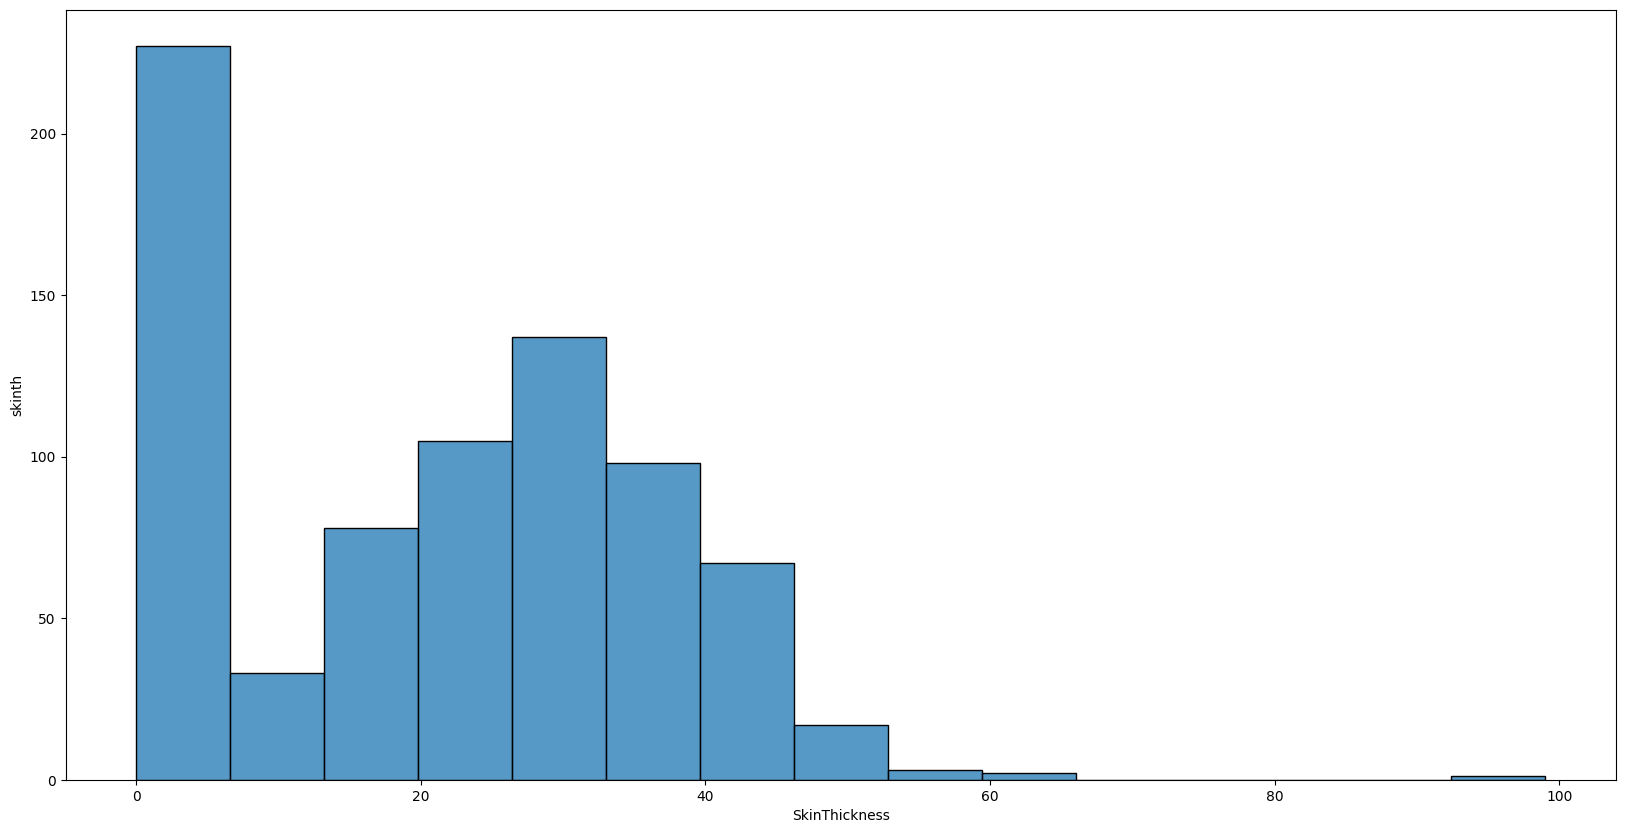

In [65]:
skin_thickness = df.select(col('SkinThickness')).toPandas()
plt.rcParams["figure.figsize"]=(20,10)
sns.histplot(data=skin_thickness, x='SkinThickness')
plt.xlabel("SkinThickness")
plt.ylabel("skinth")
plt.show()

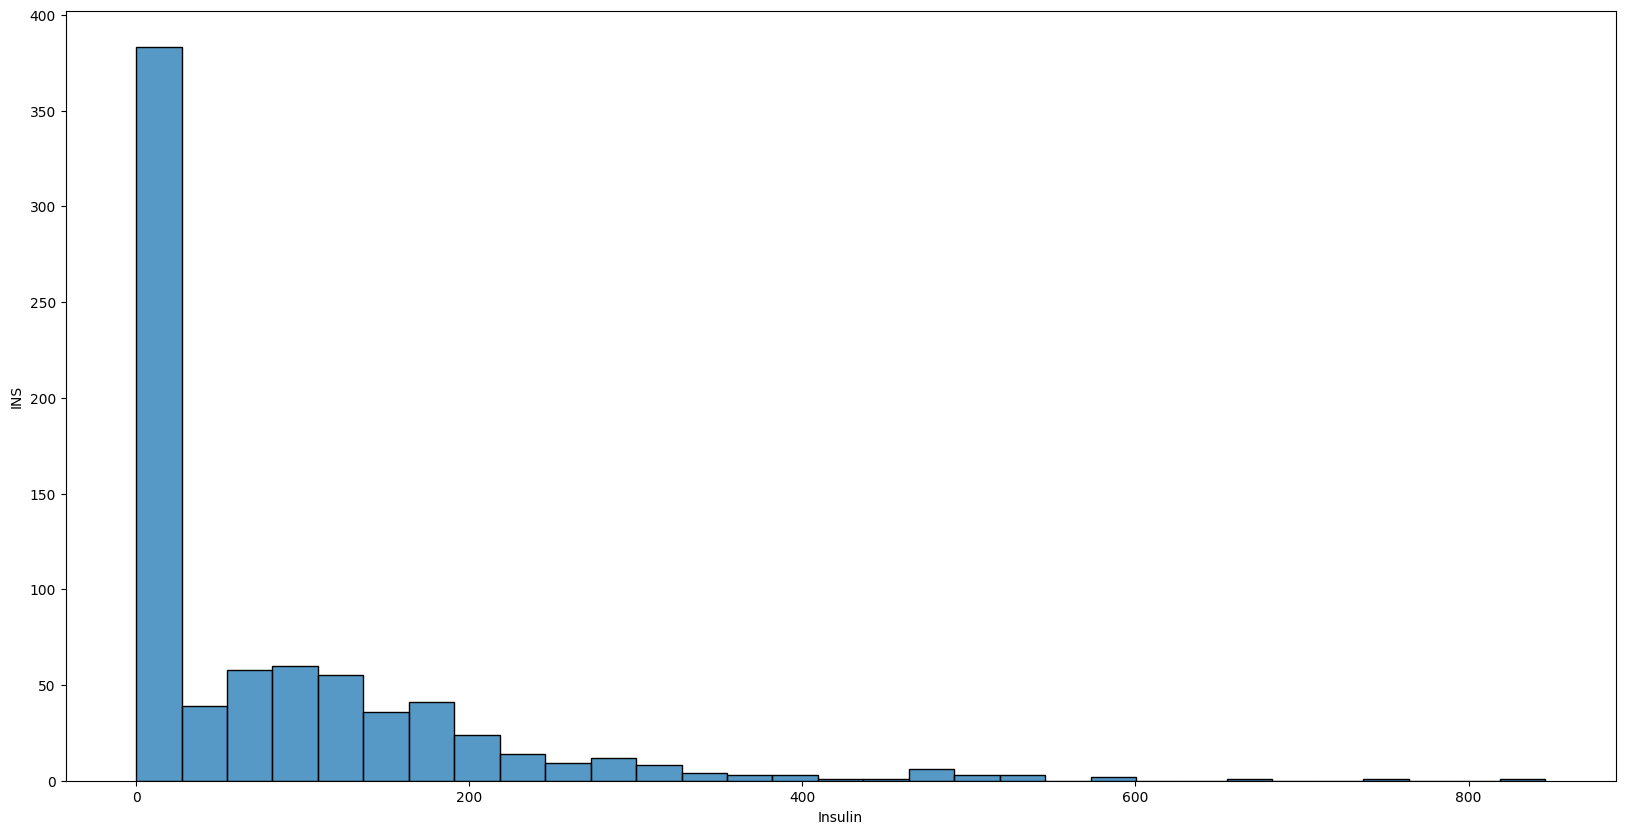

In [66]:
skin_thickness = df.select(col('Insulin')).toPandas()
plt.rcParams["figure.figsize"]=(20,10)
sns.histplot(data=skin_thickness, x='Insulin')
plt.xlabel("Insulin")
plt.ylabel("INS")
plt.show()

In [79]:
#partieml 
x = df.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age')
x.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+
|          6|    148|           72|           35|      0| 33|                       0| 50|
|          1|     85|           66|           29|      0| 26|                       0| 31|
|          8|    183|           64|            0|      0| 23|                       0| 32|
|          1|     89|           66|           23|     94| 28|                       0| 21|
|          0|    137|           40|           35|    168| 43|                       2| 33|
|          5|    116|           74|            0|      0| 25|                       0| 30|
|          3|     78|           50|           32|     88| 31|                       0| 26|
|         10|    115|            0|            0|      0| 35|                       0| 29|

In [68]:
y=df.select('Outcome')

In [69]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Define the list of input columns
input_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create a VectorAssembler to combine the input columns into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scaled_df = assembler.transform(df)

# Create a StandardScaler to scale the vector column
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Fit the StandardScaler model to the data
scaler_model = scaler.fit(scaled_df)

# Scale the data using the StandardScaler model
scaled_data = scaler_model.transform(scaled_df)

In [70]:
scaled_data.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+--------------------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|            features|      scaledFeatures|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+--------------------+--------------------+
|          6|    148|           72|           35|      0| 33|                       0| 50|      1|[6.0,148.0,72.0,3...|[1.78063837321943...|
|          1|     85|           66|           29|      0| 26|                       0| 31|      0|[1.0,85.0,66.0,29...|[0.29677306220323...|
|          8|    183|           64|            0|      0| 23|                       0| 32|      1|[8.0,183.0,64.0,0...|[2.37418449762590...|
|          1|     89|           66|           23|     94| 28|                       0| 21|      0|[1.0,89.0,66.0,23...|[0.29677306220323...|
|          0|

In [71]:
x=scaled_data
y

DataFrame[Outcome: int]

In [72]:
#x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,stratify=y,random_state=2)

In [73]:
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Define the list of input columns
input_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create a VectorAssembler to combine the input columns into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df = assembler.transform(df)

# Define the target column
target_col = 'Outcome'

# Split the data into training and testing sets
train, test = df.randomSplit([0.8, 0.2], seed=2)

# Define the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol=target_col)

# Fit the model to the training data
lr_model = lr.fit(train)

# Make predictions on the test data
predictions = lr_model.transform(test)


In [74]:
from pyspark.ml.classification import LinearSVC

# Define the list of input columns
#input_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create a VectorAssembler to combine the input columns into a single vector column
#assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
#df = assembler.transform(df)

# Define the target column
#target_col = 'Outcome'

# Split the data into training and testing sets
#train, test = df.randomSplit([0.8, 0.2], seed=2)

# Define the SVM classifier with a linear kernel
classifier = LinearSVC(maxIter=10, regParam=0.1, featuresCol='features', labelCol=target_col)

# Fit the model to the training data
svm_model = classifier.fit(train)

# Make predictions on the test data
predictions = svm_model.transform(test)


In [75]:
# Define the list of input columns
#input_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create a VectorAssembler to combine the input columns into a single vector column
#assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
#df = assembler.transform(df)

# Define the target column
#target_col = 'Outcome'

# Split the data into training and testing sets
#train, test = df.randomSplit([0.8, 0.2], seed=2)

# Define the SVM classifier with a linear kernel
#classifier = LinearSVC(maxIter=10, regParam=0.1, featuresCol='features', labelCol=target_col)

# Fit the model to the training data
#svm_model = classifier.fit(train)


In [76]:
# Make predictions on the training data
train_predictions = svm_model.transform(train)
x_train_prediction = train_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 140.0 failed 1 times, most recent failure: Lost task 0.0 in stage 140.0 (TID 117) (DESKTOP-3CCFC5I executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:76)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 15 more


In [ ]:
x_train_prediction

In [ ]:
training_data_accuracy=accuracy_score(x_train_prediction,y_train)

In [ ]:
x_test_prediction=classifier.predict(x_test)

In [ ]:
x_test_prediction

In [ ]:
test_data_accuracy=accuracy_score(x_test_prediction,y_test)

In [ ]:
input_data=(4,110,92,0,0,37.6,0.191,30)
# changing the input data to numpy array 
input_data_as_numpy_array=np.array(input_data)
input_data_as_numpy_array

In [ ]:
 # reshape the array as we are predictinf gor one insatnce 
input_data_reshaped=input_data_as_numpy_array.reshape(1,-1)
input_data_reshaped

In [ ]:
# standardize the input data 
std_data=scaler.transform(input_data_reshaped)

In [ ]:
std_data

In [ ]:
prediction=classifier.predict(std_data)

In [ ]:
print(prediction)

In [ ]:
if (prediction[0]==0):
    print('the person is not diabetic')
else : 
    print('the person is diabetic ')

In [ ]:
# taking another example 
input_data=(5,166,72,19,175,25.8,0.587,51)
# changing the input data to numpy array 
input_data_as_numpy_array=np.asarray(input_data)
# reshape the array as we arae predicting for one instance 
input_data_reshaped=input_data_as_numpy_array.reshape(1,-1)
# STANDARDIZE THE INPUT DATA 
std_data=scaler.transform(input_data_reshaped)
print(std_data)
prediction=classifier.predict(std_data)
print(prediction)

In [ ]:
if(prediction[0]==0):
    print('the person is not diabetic')
else :
    print('the person is diabetic ')

## Merci pour votre attention